# Scenario Building

In [105]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
import time
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from kneed import KneeLocator

#make plot default more academic (bold axis, etc)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 12


In [106]:
#import the necessary data
# Load the simulated load data
sim_data = pd.read_csv('sim_data.csv')
# Load the solar and wind data
solar_data = pd.read_csv('solarfinalannum.csv')
wind_data = pd.read_csv('WindFinal.csv')
kwperturbine = 100
#make nuclear data with the same first column and a second column ('kWh') of matching length with repeated 2000s
nuclear_data = pd.DataFrame(sim_data['Date'])
nuclear_data['kWh'] = 2000.0 #set the eletrical capacity of the nuclear plant 

sim_data.set_index('Date', inplace=True)
solar_data.set_index('Date', inplace = True)
wind_data.set_index('Date', inplace = True)
nuclear_data.set_index('Date', inplace = True)
#convert all indices to datetime
sim_data.index = pd.to_datetime(sim_data.index)
solar_data.index = pd.to_datetime(sim_data.index)
wind_data.index = pd.to_datetime(sim_data.index)
nuclear_data.index = pd.to_datetime(sim_data.index)

demand = sim_data['kWh']
batteff = .90
#check tht the lengths are equal
#print max demand
print(demand.max())
print(demand.min())
#print sum of simulated demand
print(demand.sum())

1431.0
481.4408484479078
8028710.294325117


In [107]:
#Diesel function
def calculate_diesel(unmet_demand):
    diesel = []
    fuel = []
    i  = unmet_demand
    opcap = 500
    coeffs = [-1.03886878e-06,  2.70529957e-04, -2.68484638e-02,  1.36302395e+00, 1.29690135e+00] # fit to diesel efficiency curve

    def galcalc(opcap, op):
        outp = op/opcap*100
        eff = p(outp)/100  # Assuming p is a function defined elsewhere in your code
        kwh = op/eff
        gal = kwh/37.5
        return gal

    p = np.poly1d(coeffs)
    if i > -.001:
        diesel = (0)
        fuel = (0)
    else:
        if i > -250:
            diesel = 250
            opcap = 500
            fuel = galcalc(opcap, 250)
        elif i > -500:
            diesel = (-i)
            opcap = 500
            fuel = (galcalc(opcap, -i))
        elif i > -750:
            opcap = 750
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        elif i > -1200:
            opcap = 1200
            diesel = (-i)
            fuel = (galcalc(opcap, -i))
        else:
            opcap = 1700
            diesel = (-i)
            fuel = (galcalc(opcap, -i))

    return diesel, fuel

In [108]:
#Energy Simulation Function
def simulate_energy(scenario):
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battpower = scenario[3]
    battcap = scenario[4]*.6
    dieselstatus = scenario[5]
    # Use the function arguments to calculate wind, solar, and nuclear
    wind = turbinenumber*wind_data['kWh']
    solar = solarcount*solar_data['kWh']
    nuclear = nucleargens*nuclear_data['kWh']
  
    supplytotal = wind + solar + nuclear
   
    #power system calculation
    #Battery
    battery = []
    charge = battcap
    discharge = []
    curtailed = []
    diesel = []
    fuel = []
    curtail = 0
    for i in supplytotal - demand:
            icharge = charge
            if i > 0.0000001:
                if i > battpower:
                    charge = charge + battpower*batteff
                    curtail = i-battpower
                else:
                    charge = charge + i*batteff
                    curtail = 0 
                if charge > battcap:
                    curtail = curtail + icharge+(charge-icharge)/batteff - battcap
                    charge = battcap
                battery.append(charge)
                discharge.append(0)
                curtailed.append(curtail)
                diesel.append(0)
                fuel.append(0)
            else:
                if dieselstatus == 0:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    curtailed.append(0)
                    diesel.append(0)
                    fuel.append(0)
                else:
                    if i < -battpower:
                        charge = charge - battpower
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(battpower*batteff)
                    else:
                        charge = charge + i/batteff
                        if charge <= 0:
                            discharge.append(icharge*batteff)
                            charge = 0
                        else:
                            discharge.append(-i)
                    battery.append(charge)
                    if i+discharge[-1] >= 0-.0000001:
                        diesel.append(0)
                        fuel.append(0)
                    else:   
                        dieseln, fueln = calculate_diesel(i+discharge[-1])
                        fuel.append(fueln)
                        diesel.append(dieseln)
                        if dieseln + i +discharge[-1] > 0-.0000001 and discharge[-1] > 0:
                            discharge[-1] = discharge[-1]-(discharge[-1]+dieseln + i)
                            battery[-1] = battery[-1] + discharge[-1] + dieseln + i
                    curtailed.append(0)
                if diesel[-1] + i + discharge[-1]> 0-.00000001 and diesel[-1] != 0:
                    curtailed[-1] = diesel[-1] + i + discharge[-1]

    
        # Calculate the total supply
    supplytotal = wind + solar + nuclear + discharge + diesel

    fuel_data = pd.DataFrame(sim_data.index)
    fuel_data['gal'] = fuel
    fuel_data.set_index('Date', inplace = True)
    fuel_data = fuel_data.round(2)
    #make fuel data cumulative
    fuel_data['cumulative'] = fuel_data['gal'].cumsum()

    fuel = np.array(fuel_data['cumulative'])

    battery = np.array(battery)
    battery_data = pd.DataFrame(sim_data.index)
    battery_data['kWh'] = battery
    battery_data.set_index('Date', inplace = True)
    
    #create the discharge DataFrame
    discharge = np.array(discharge)
    discharge_data = pd.DataFrame(sim_data.index)
    discharge_data['kWh'] = discharge
    discharge_data.set_index('Date', inplace = True)

    #create the curtailed DataFrame
    curtailed = np.array(curtailed)
    curtailed_data = pd.DataFrame(sim_data.index)
    curtailed_data['kWh'] = curtailed
    curtailed_data.set_index('Date', inplace = True)
    #make curtailed data cumulative
    curtailed_data['cumulative'] = curtailed_data['kWh'].cumsum()
    curtailedcum = np.array(curtailed_data['cumulative'])
    
    count = 0
    for s, d in zip(supplytotal, demand):
        if s >= d-.000000001:
            count += 1
    
    #return the total amount of fuel used
    # Create a DataFrame with data for each generation type, fuel usage, and curtailed electricity
    data = pd.DataFrame({
        'Wind': wind,
        'Solar': solar,
        'Nuclear': nuclear,
        'Battery': discharge,
        'Diesel': diesel,
        'Fuelcum': fuel,  
        'Curtailed': curtailed,
        'Curtailedcum': curtailedcum,
        'Metdemand' : count
    }, index=sim_data.index)
    
    return data
    # Return number of hours with satisfied demand


In [109]:
#Carbon Measurement Function
def calculate_carbon(scenario):
    # Calculate the carbon emissions for each generation type
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battcap = scenario[4]
    dieselstatus = scenario[5]
    data = simulate_energy(scenario)
    fuel = data['Fuelcum']
    curtailed = data['Curtailedcum']
    #stage emissions data
    kwperturbine = 100 #kW
    dieselpower = 500 #kW
    solarembodied = 0.278267*1000*.66666666 #kgCO2/kWp modified for 20 years
    windembodied =  2615 * kwperturbine ** .7462 #kgCO2/turbine
    batteryembodied = 110 #kg/kWh modified for 20 years
   

    # #B stage emissions
    jp5emissions = 9.8 #kgCO2/gal

    # #Calculate total emissions for the A stage (pre)
    # A = (solarcount*solarA + turbinenumber*windA*kwperturbine + nucleargens*nuclearA + battA*battcap)/1000 #kgCO2
    # #Calulcate emissions in the B stage (use-during)
    fuelshipment = 100000 #gallons
    galpertonne = 328.36 #gallons
    shipcarbon = 10.6 #CO2e g/tkm
    carbonpershipment = fuelshipment/galpertonne*shipcarbon/1000 #kgCO2
    dist = 150 # km
    carbonpershipment = fuelshipment/galpertonne*shipcarbon*dist/1000 #kgCO2
    B = (fuel.iloc[-1]*jp5emissions)+fuel.iloc[-1]/fuelshipment*carbonpershipment#kgCO2 #high PM2.5 emissions #fuel transport
    B = B*20 #20 years of data 
    # #Calculate emissions in the C stage (End of Life)
    # C = (solarcount*solarC + turbinenumber*windC*kwperturbine + nucleargens*nuclearC + battC*battcap)/1000 #kgCO2

    # #Calculate total emissions
    embodied = solarcount*solarembodied + turbinenumber*windembodied + battcap*batteryembodied  
    total = B + embodied

    total = total/1000
    B = B/1000
    embodied = embodied/1000
    return total, B, embodied, fuel.iloc[-1],curtailed.iloc[-1]

In [110]:
# Plot Gen: Time Period
def plot_generation(data, start, end):
    # Create a new DataFrame with only the data between the start and end dates
    data_subset = data[start:end].copy()
    data_subset['Day'] = range(len(data_subset))  # Add a 'Day' column
    data_subset['Day'] = data_subset['Day']/24

    plt.figure(figsize=(12, 6))
    colors = ['red', 'blue', 'yellow', 'green']  # Specify your own colors here
    stack_plots = plt.stackplot(data_subset['Day'], data_subset['Diesel'], data_subset['Battery'], data_subset['Solar'], data_subset['Wind'], colors=colors)

    # Add a dotted line that traces demand for the two summer days
    demand_line = plt.plot(data_subset['Day'], demand[start:end], 'k--', label = 'Demand')  # Assuming demand is defined somewhere in your code

    # Calculate total energy for the two summer days
    total_energy = data_subset['Diesel'] + data_subset['Battery'] + data_subset['Solar'] + data_subset['Wind']

    # Shade the area between the stacked plot and the curtailed line
    curtailed_fill = plt.fill_between(data_subset['Day'], total_energy, total_energy - data_subset['Curtailed'], color='red', alpha=0.5, hatch='///')
    curtailed_patch = mpatches.Patch(color='red', alpha=0.5, hatch='///', label='Curtailed Energy')

    plt.xlabel('Days')
    plt.ylabel('kWh Generated')
    plt.title('Simulated Generation')

    # Create the first legend and add it to the plot
    first_legend = plt.legend(stack_plots[::-1], ['Diesel', 'Battery', 'Solar', 'Wind'][::-1], loc='upper left')
    plt.gca().add_artist(first_legend)

    # Create the second legend and add it to the plot
    plt.legend([demand_line[0], curtailed_patch], ['Demand', 'Curtailed Energy'], loc='upper right')    

    plt.show()

In [111]:
def calculate_cost(scenario):
    # Calculate the carbon emissions for each generation type
    turbinenumber = scenario[0]
    solarcount = scenario[1]
    nucleargens = scenario[2]
    battcap = scenario[4]
    dieselstatus = scenario[5]
    data = simulate_energy(scenario)
    fuel = data['Fuelcum']
    curtailed = data['Curtailedcum']
    #stage emissions data
    kwperturbine = 100 #kW
    dieselpower = 500 #kW
    solarembodied = 876 #cost per k2
    windembodied =  1274 #cost per kw
    batteryembodied = 500 #dollars per kWh

    B = (fuel.iloc[-1]*4.92)*20#cost of fuel for 20 years 2% increase per year
    # #Calculate emissions in the C stage (End of Life)
    # C = (solarcount*solarC + turbinenumber*windC*kwperturbine + nucleargens*nuclearC + battC*battcap)/1000 #kgCO2

    # #Calculate total emissions
    embodied = solarcount*solarembodied + turbinenumber*windembodied*kwperturbine + battcap*batteryembodied  
    total = B + embodied
   
    return total,B,embodied

In [112]:
def find_stable_x(x, y, threshold=0.0005):
    for i in range(1, len(y)):
        change = abs(y[i] - y[i-1]) / y[i-1]
        if change < threshold:
            return x[i]
    return None

# Scenario Design

### Base

(122665.73403624086, 122665.73403624086, 0.0, 625536.5000000007, 0.0)


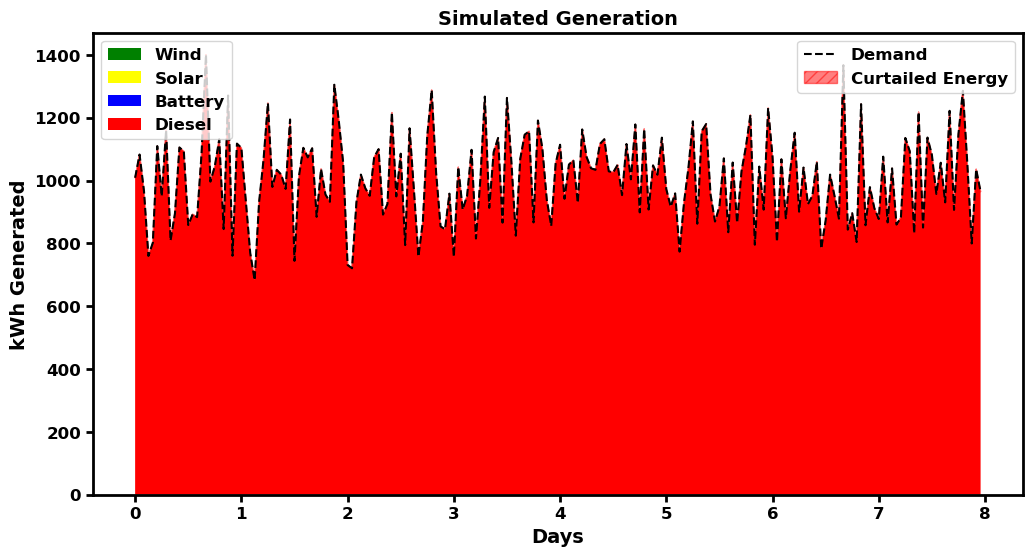

In [113]:
base = [0,0,0,0,0,1]
print(calculate_carbon(base))

plot_generation(simulate_energy(base), '1999-5-3', '1999-5-10')

### Solar 

2900
8800
14900


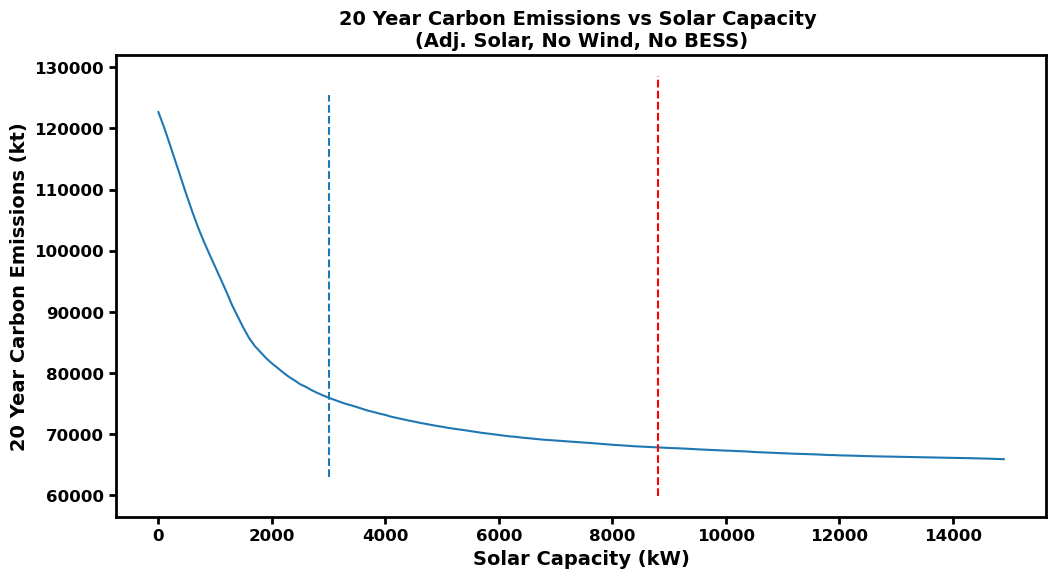

In [114]:
# Solar Sizing No battery
solsize = solsize = np.arange(0, 15000, 100)
fdem = []
for i in solsize:
    scenario = [0, i, 0, 0, 0, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(solsize, fdem)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs Solar Capacity \n(Adj. Solar, No Wind, No BESS)')
#set bottom y to 0
#plt.ylim(0, 130000000)
#print the solar for lowest emissions
knee_locator = KneeLocator(solsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(3000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(find_stable_x(solsize, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
print(elbow_point)
print(find_stable_x(solsize, fdem))
print(solsize[np.argmin(fdem)])


(75955.08256867141, 75398.54857423675, 556.5339944346599, 384496.4899999997, 2328288.176165181)


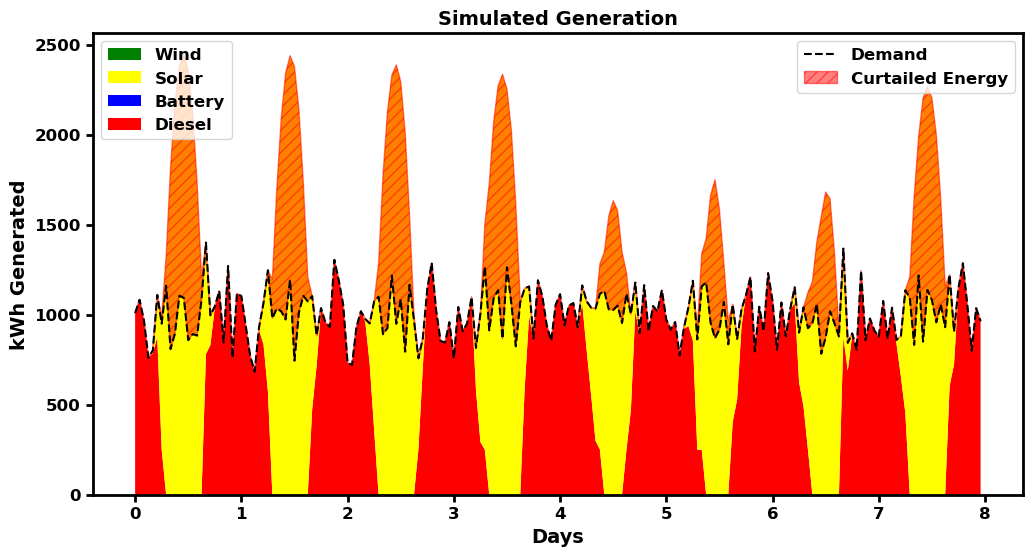

In [115]:
solar1 = [0,3000, 0,0, 0,1]
print(calculate_carbon(solar1))
plot_generation(simulate_energy(solar1), '1999-5-3', '1999-5-10')

(67827.01344132096, 66194.51372431262, 1632.499717008336, 337560.3200000014, 12256939.254335886)


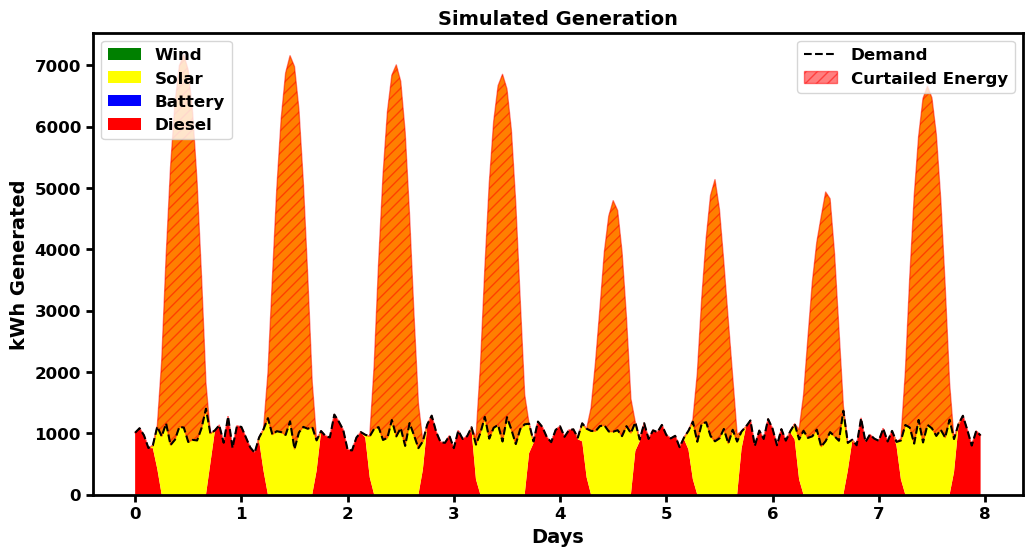

In [116]:
solar2 = [0,8800, 0,0, 0,1]
print(calculate_carbon(solar2))
plot_generation(simulate_energy(solar2), '1999-5-3', '1999-5-10')

### Solar + BESS

12000
15000


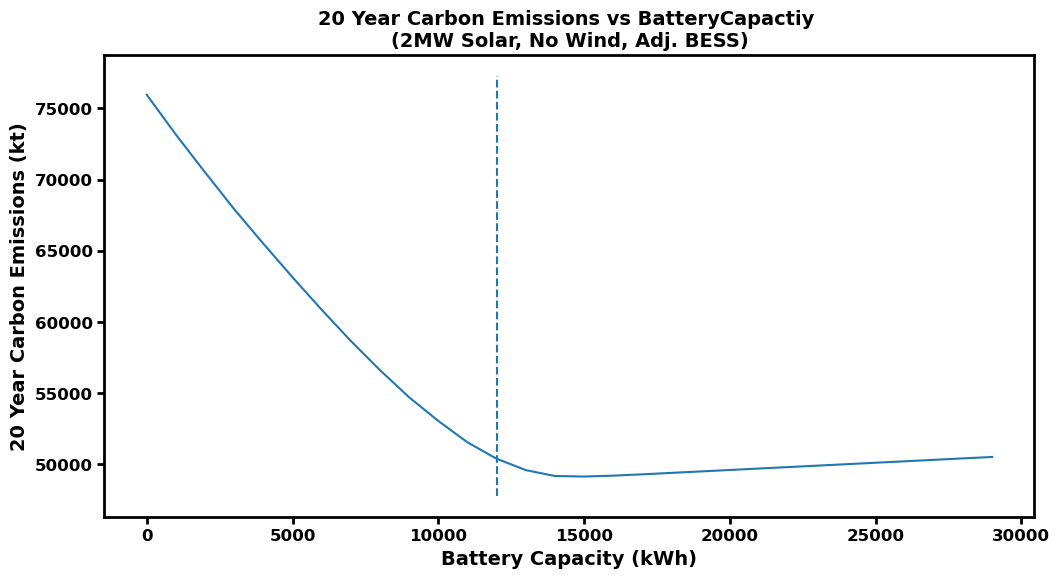

In [117]:
#solar 2000
batsize = np.arange(0, 30000, 1000)
fdem = []
for i in batsize:
    scenario = [0, 3000, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(2MW Solar, No Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(12000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(50397.98429111435, 48521.45029667969, 1876.53399443466, 247436.16000000222, 155526.98507966934)


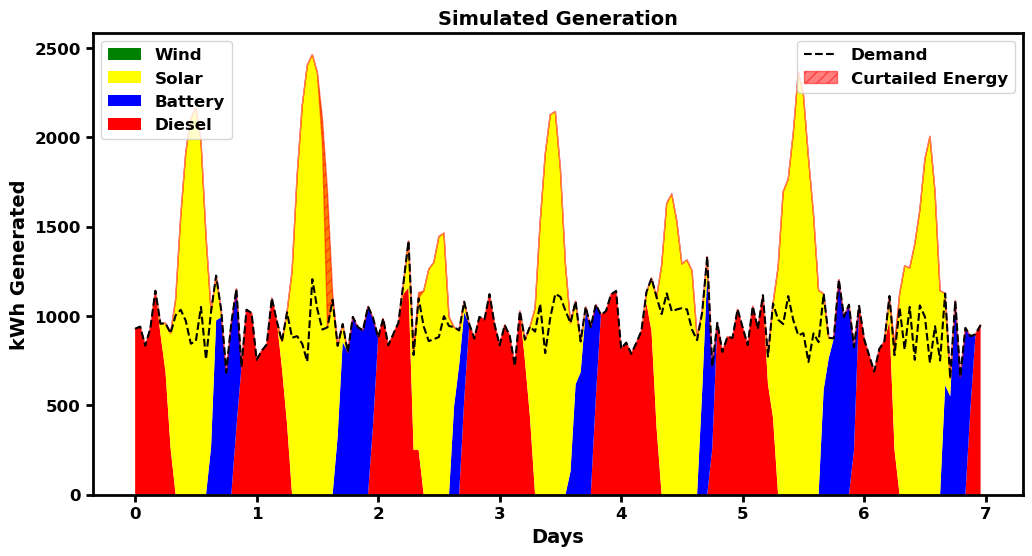

In [118]:
solarBESS1 = [0,3000, 0, 2000, 12000,1]
print(calculate_carbon(solarBESS1))
plot_generation(simulate_energy(solarBESS1), '1999-4-1', '1999-4-7')

19000
26000


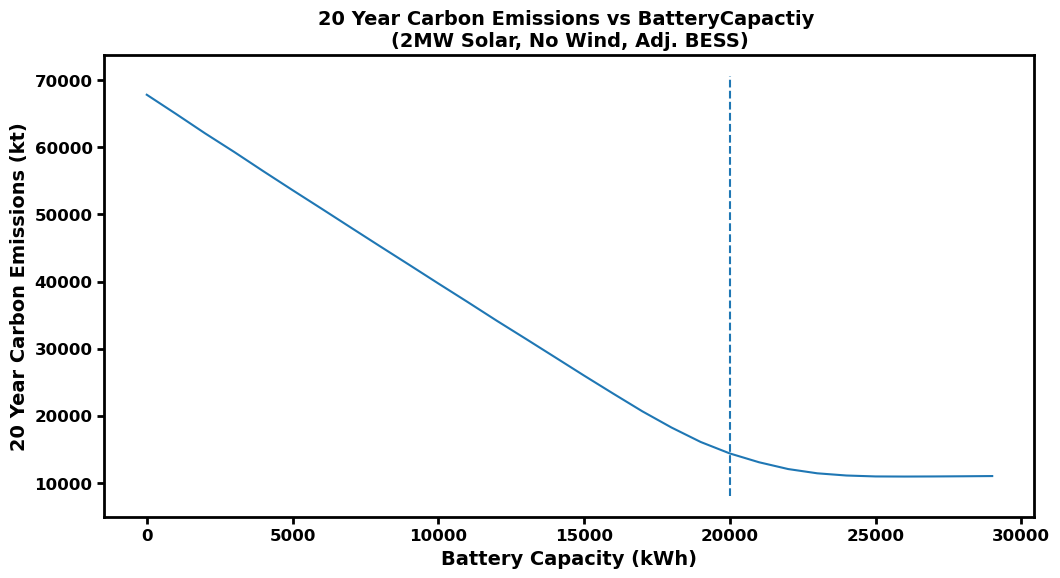

In [119]:
#solar 2000
batsize = np.arange(0, 30000, 1000)
fdem = []
for i in batsize:
    scenario = [0, 8800, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(2MW Solar, No Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(20000, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(14389.543967870826, 10557.044250862491, 3832.499717008336, 53835.870000000104, 7803662.1725078495)


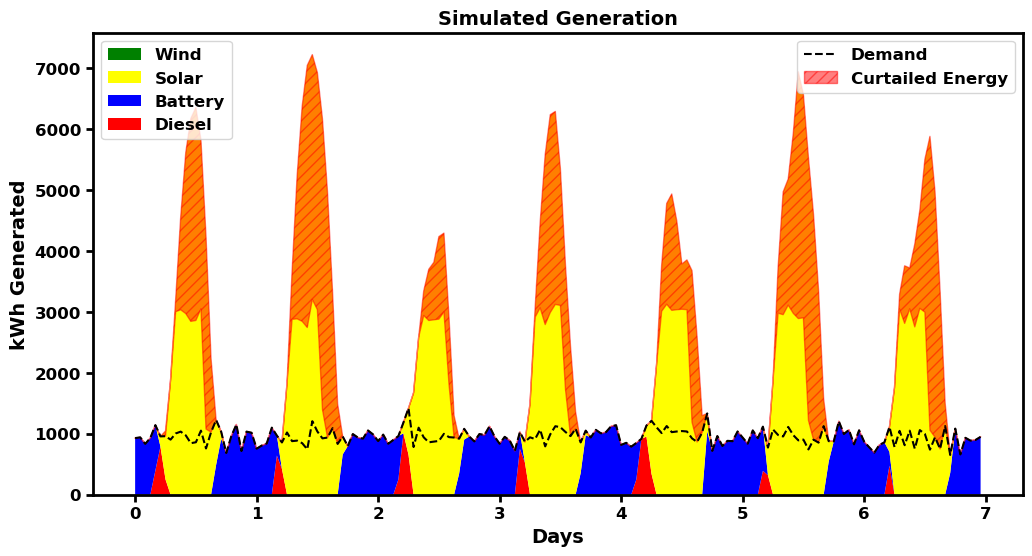

In [120]:
solarBESS2 = [0,8800, 0, 2000, 20000,1]
print(calculate_carbon(solarBESS2))
plot_generation(simulate_energy(solarBESS2), '1999-4-1', '1999-4-7')

### Wind

4500
14000
160


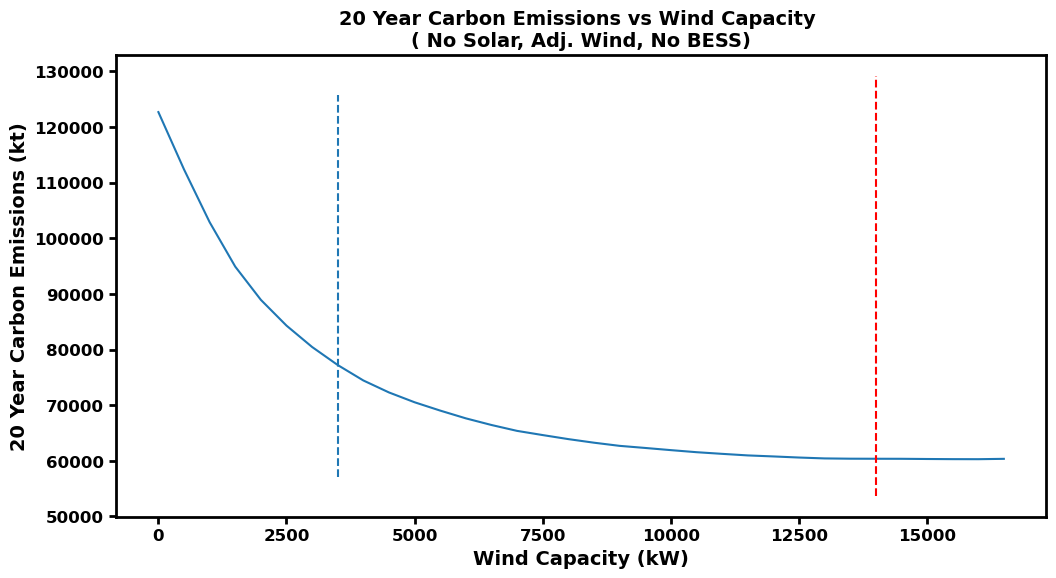

In [121]:
# same for wind
windsize = np.arange(0, 170, 5)
fdem = []
for i in windsize:
    scenario = [i, 0, 0, 0, 0, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(windsize*kwperturbine, fdem)
plt.xlabel('Wind Capacity (kW)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs Wind Capacity \n( No Solar, Adj. Wind, No BESS)')
knee_locator = KneeLocator(windsize*kwperturbine, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(3500, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.vlines(find_stable_x(windsize*kwperturbine, fdem), plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
print(elbow_point)
print(find_stable_x(windsize*kwperturbine, fdem))

#print the wind for lowest emissions
print(windsize[np.argmin(fdem)])


(74441.61711357725, 71191.25546891078, 3250.361644666461, 363041.3099999991, 2308697.2344546877)


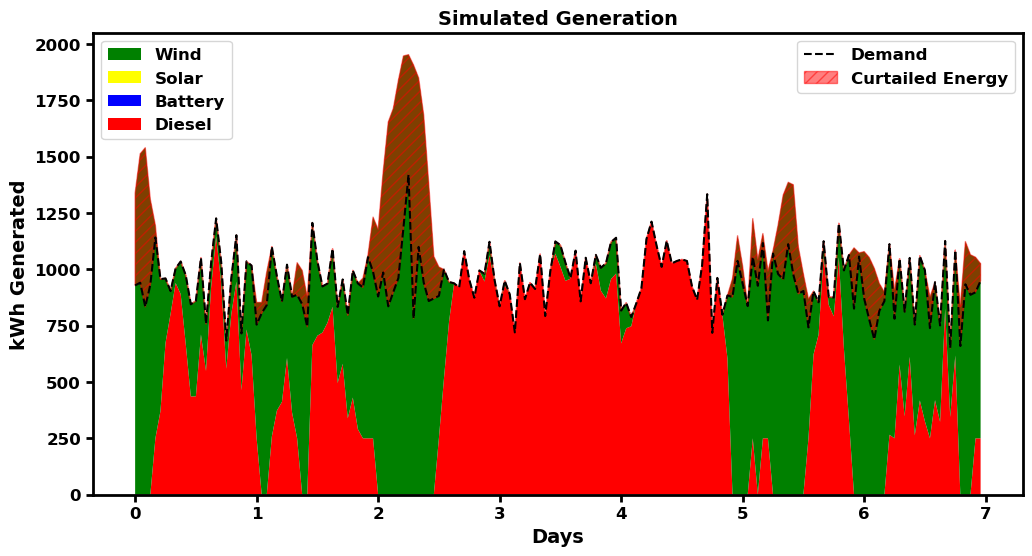

In [122]:
wind1 = [40,0, 0, 0, 0,1]
print(calculate_carbon(wind1))
plot_generation(simulate_energy(wind1), '1999-4-1', '1999-4-7')

(61925.102931723995, 53799.19882005785, 8125.904111666152, 274350.150000003, 9748011.426719565)


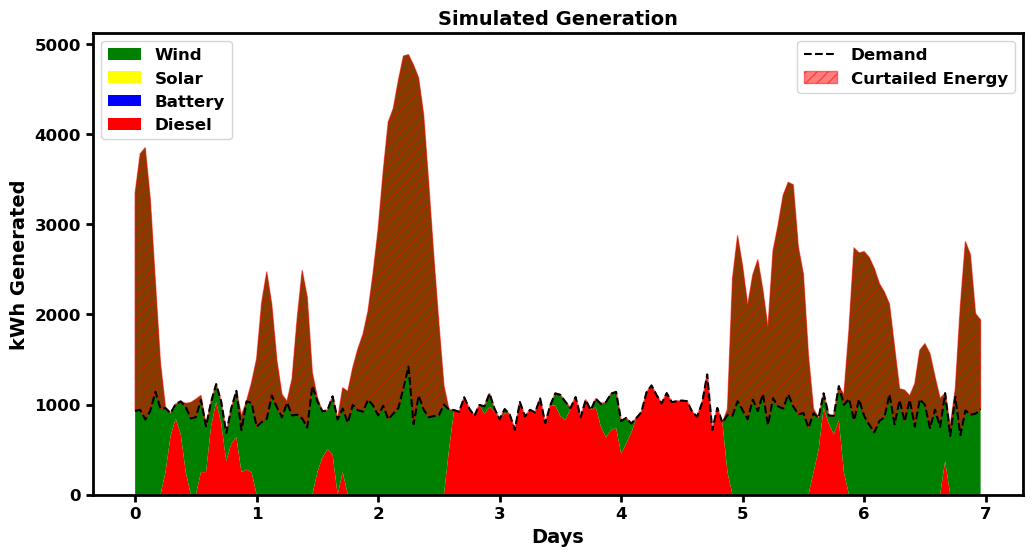

In [123]:
wind2 = [100,0, 0, 0, 0,1]
print(calculate_carbon(wind2))
plot_generation(simulate_energy(wind2), '1999-4-1', '1999-4-7')

### Wind +BESS

27000
66000


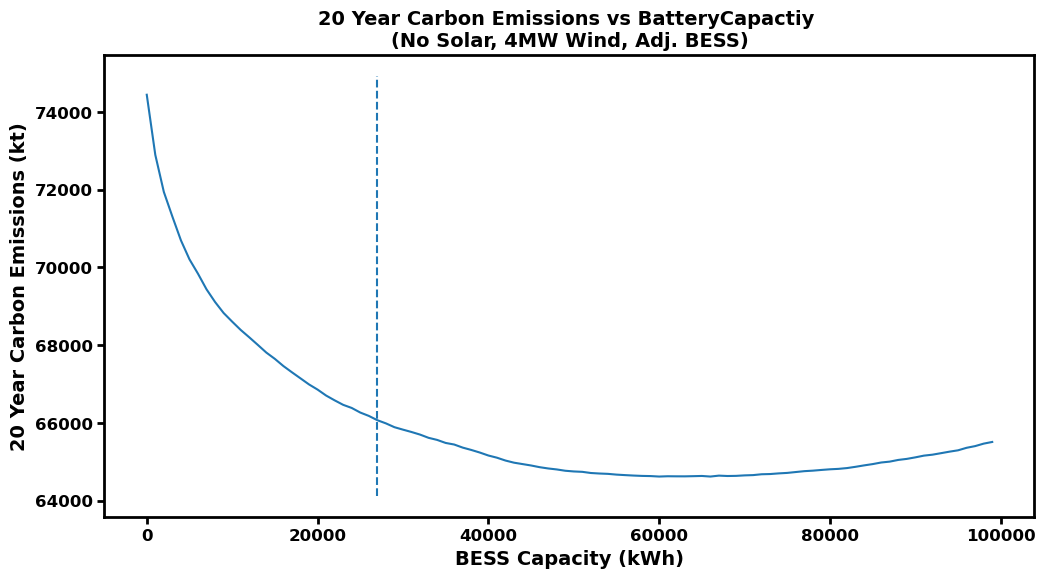

In [124]:
# same for wind (4000 kW)
#solar 2000
batsize = np.arange(0, 100000, 1000)
fdem = []
for i in batsize:
    scenario = [40, 0, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('BESS Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(No Solar, 4MW Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])


(68201.50525597605, 63631.14361130959, 4570.361644666461, 324488.3600000002, 1716213.8250752415)


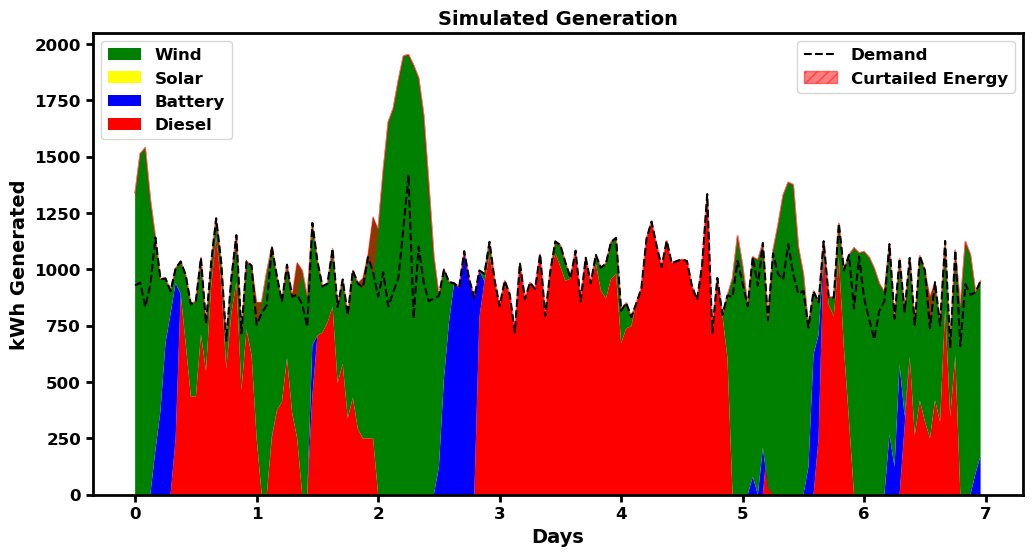

In [125]:
windBESS1 = [40,0, 0, 2000, 12000,1]
print(calculate_carbon(windBESS1))
plot_generation(simulate_energy(windBESS1), '1999-4-1', '1999-4-7')


55000
98000


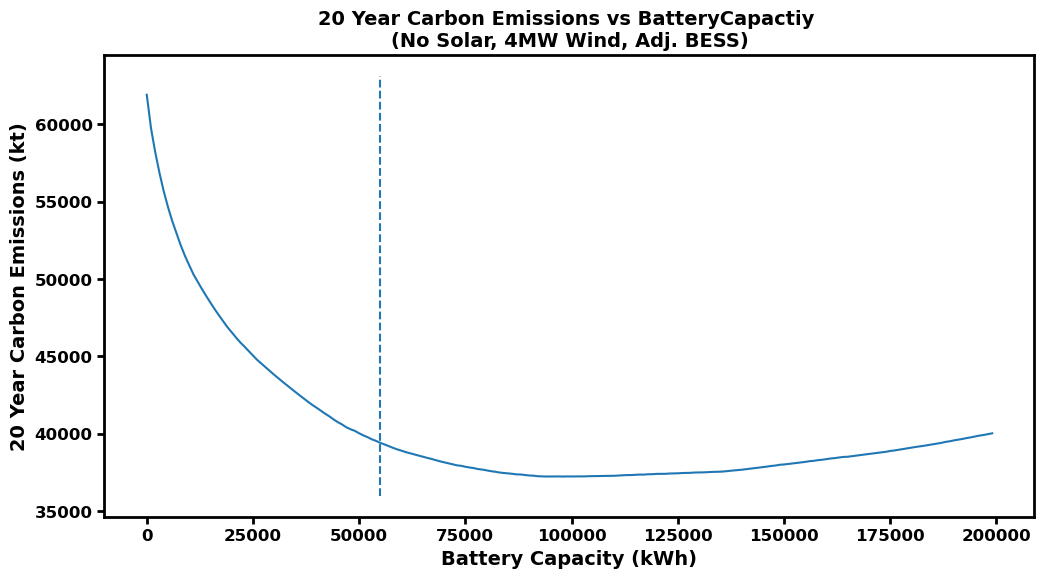

In [126]:
# same for wind (10000 kW)
#solar 2000
batsize = np.arange(0, 200000, 1000)
fdem = []
for i in batsize:
    scenario = [100, 0, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(No Solar, 4MW Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(46554.45892522713, 36228.554813560986, 10325.904111666152, 184748.28000000134, 8359029.919501088)


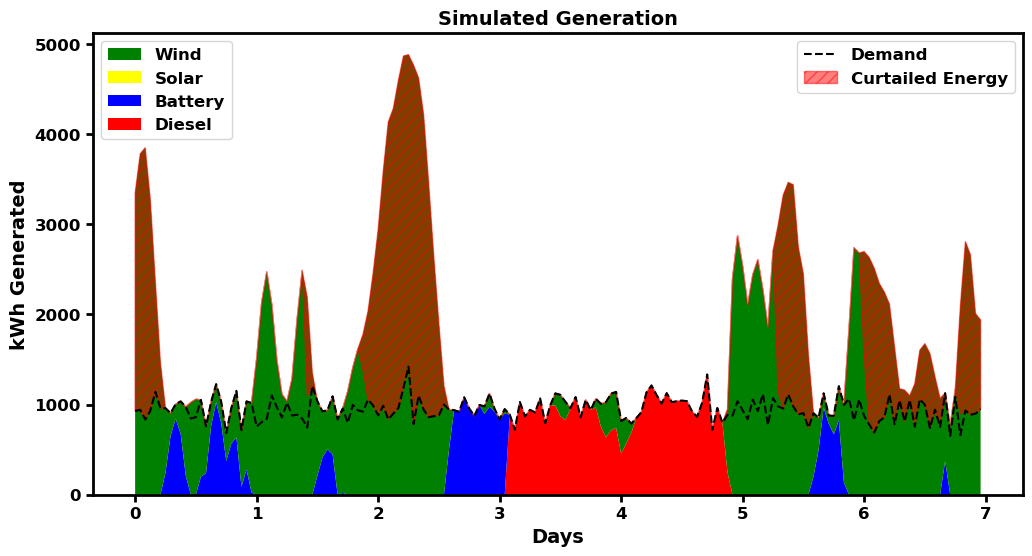

In [127]:
windBESS2 = [100,0, 0, 2000, 20000,1]
print(calculate_carbon(windBESS2))
plot_generation(simulate_energy(windBESS2), '1999-4-1', '1999-4-7')

### Hybrid All


7000
29000


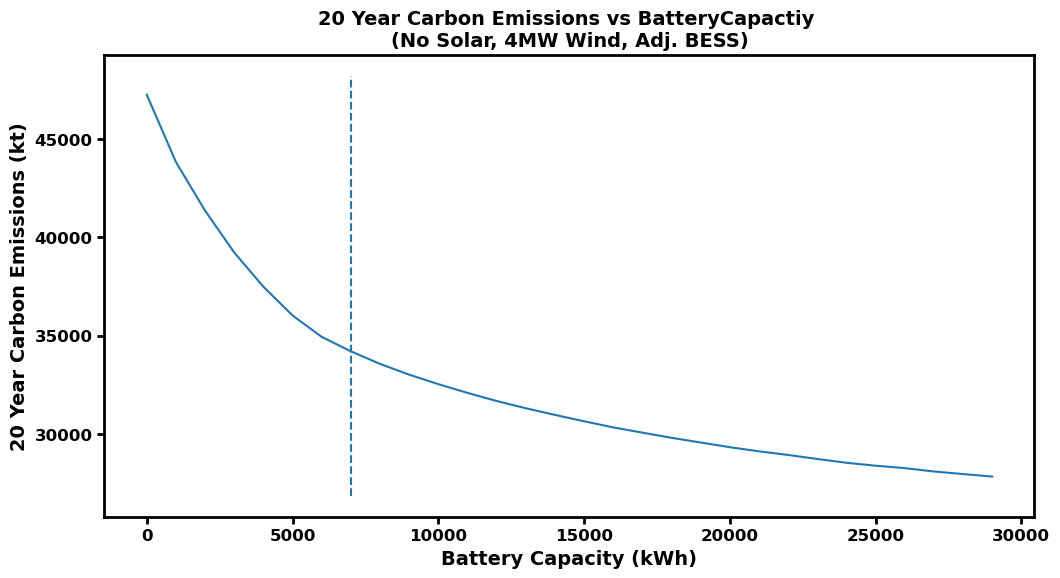

In [128]:
# Solar 2000 kw and wind 4000 kw
batsize = np.arange(0, 30000, 1000)
fdem = []
for i in batsize:
    scenario = [40, 2000, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(No Solar, 4MW Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(21657.03409867114, 16530.138459570022, 5126.895639101121, 84295.79000000018, 3858816.2900112546)


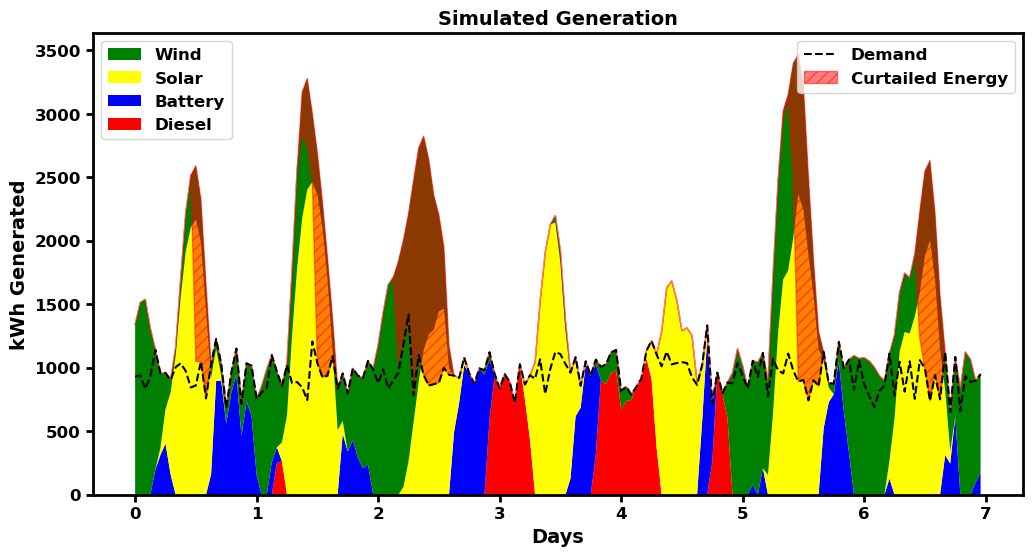

In [129]:
hybrid1 = [40,3000, 0, 2000, 12000,1]
print(calculate_carbon(hybrid1))
plot_generation(simulate_energy(hybrid1), '1999-4-1', '1999-4-7')

12000
25000


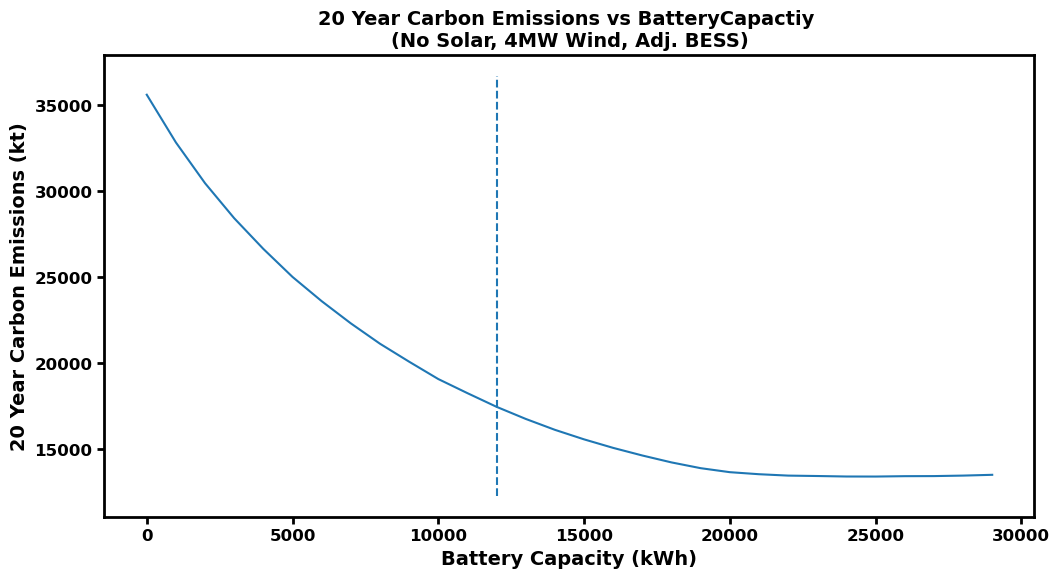

In [130]:
# Solar 6000 kw and wind 10000 kw
batsize = np.arange(0, 30000, 1000)
fdem = []
for i in batsize:
    scenario = [100, 6000, 0, 2000, i, 1]
    fdem.append(calculate_carbon(scenario)[0])

plt.figure(figsize=(12, 6))
plt.plot(batsize, fdem)
plt.xlabel('Battery Capacity (kWh)')
plt.ylabel('20 Year Carbon Emissions (kt)')
plt.title('20 Year Carbon Emissions vs BatteryCapactiy \n(No Solar, 4MW Wind, Adj. BESS)')
knee_locator = KneeLocator(batsize, fdem, curve='convex', direction='decreasing')
elbow_point = knee_locator.knee
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(elbow_point)
#print the battery for lowest emissions
print(batsize[np.argmin(fdem)])

(13472.206759546702, 1513.8029308722125, 11958.403828674487, 7719.669999999995, 21994530.899885785)


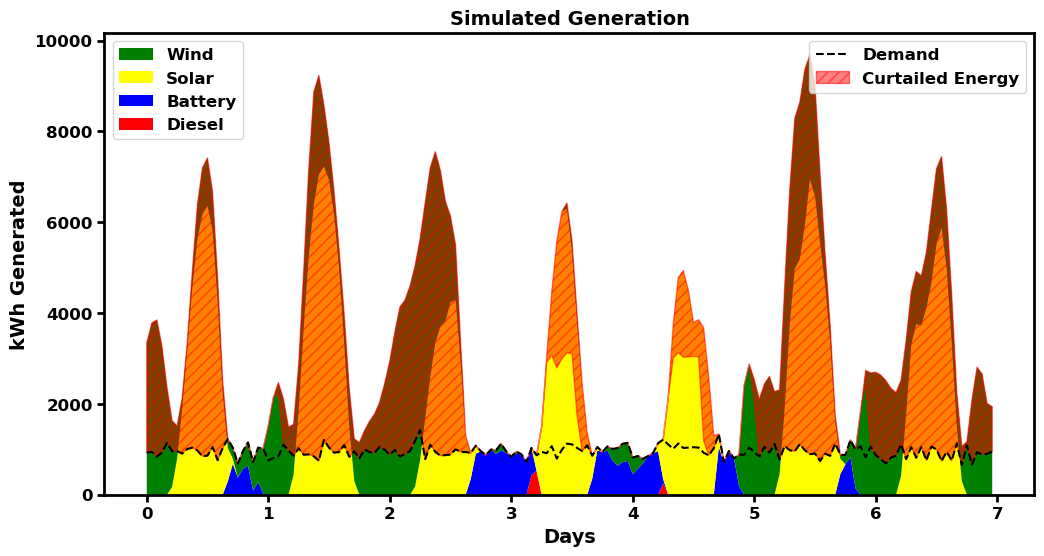

In [131]:
hybrid2 = [100,8800, 0, 2000, 20000,1]
print(calculate_carbon(hybrid2))
plot_generation(simulate_energy(hybrid2), '1999-4-1', '1999-4-7')

### Renewable

(11948.741390682662, 0.0, 11948.741390682662, 0, 50062190.219784476)


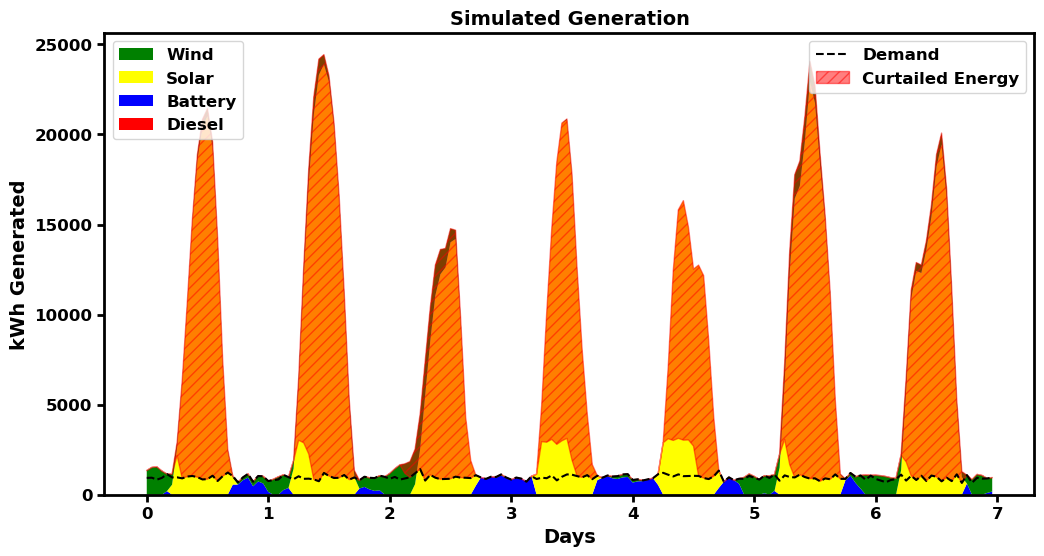

In [132]:
renewable1 = [40,29100, 0, 2000, 30000,0]
print(calculate_carbon(renewable1))
plot_generation(simulate_energy(renewable1), '1999-4-1', '1999-4-7')

(11948.741390682662, 0.0, 11948.741390682662, 0, 50062190.219784476)


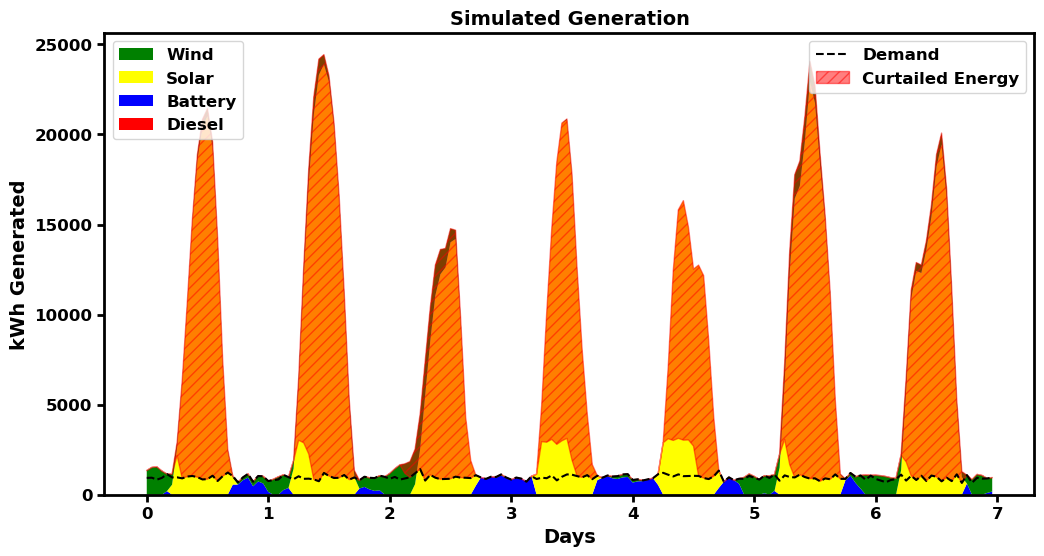

In [133]:
renewable1 = [40,29100, 0, 2000, 30000,0]
print(calculate_carbon(renewable1))
plot_generation(simulate_energy(renewable1), '1999-4-1', '1999-4-7')

(15977.465727317203, 0.0, 15977.465727317203, 0, 55847453.20042942)


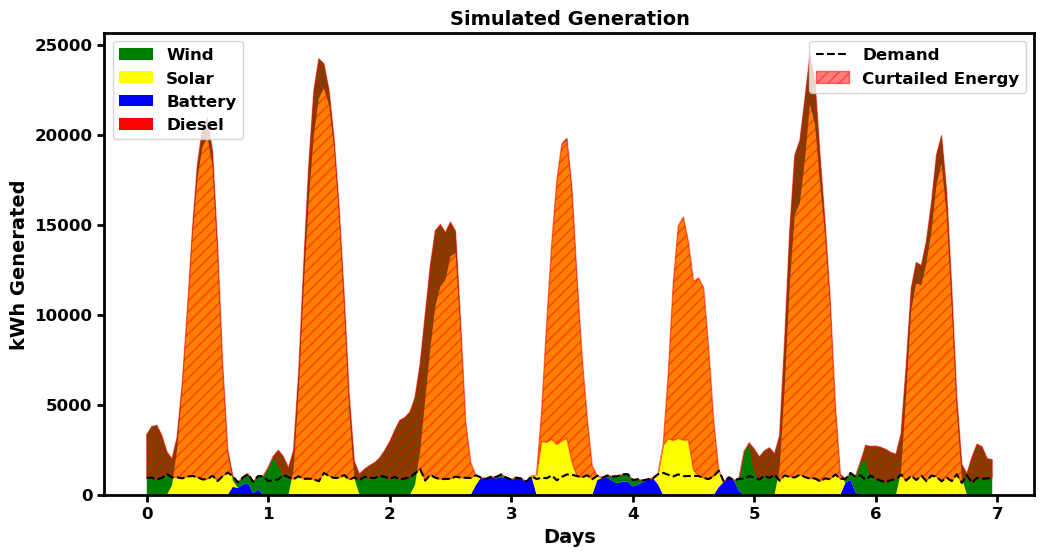

In [134]:
renewable2 = [100,27500, 0, 2000, 25000,0]
print(calculate_carbon(renewable2))
plot_generation(simulate_energy(renewable2), '1999-4-1', '1999-4-7')

## Scenarios

In [135]:
print((base))
print((solar1))
print((solar2))
print((solarBESS1))
print((solarBESS2))
print((wind1))
print((wind2))
print((windBESS1))
print((windBESS2))
print((hybrid1))
print((hybrid2))
print((renewable1))
print((renewable2))

[0, 0, 0, 0, 0, 1]
[0, 3000, 0, 0, 0, 1]
[0, 8800, 0, 0, 0, 1]
[0, 3000, 0, 2000, 12000, 1]
[0, 8800, 0, 2000, 20000, 1]
[40, 0, 0, 0, 0, 1]
[100, 0, 0, 0, 0, 1]
[40, 0, 0, 2000, 12000, 1]
[100, 0, 0, 2000, 20000, 1]
[40, 3000, 0, 2000, 12000, 1]
[100, 8800, 0, 2000, 20000, 1]
[40, 29100, 0, 2000, 30000, 0]
[100, 27500, 0, 2000, 25000, 0]


(44103.10887762158, 40296.21323852046, 3806.8956391011207, 205491.39000000272, 5731455.637967833)
(27944352.77600027, 20220352.77600027, 7724000)


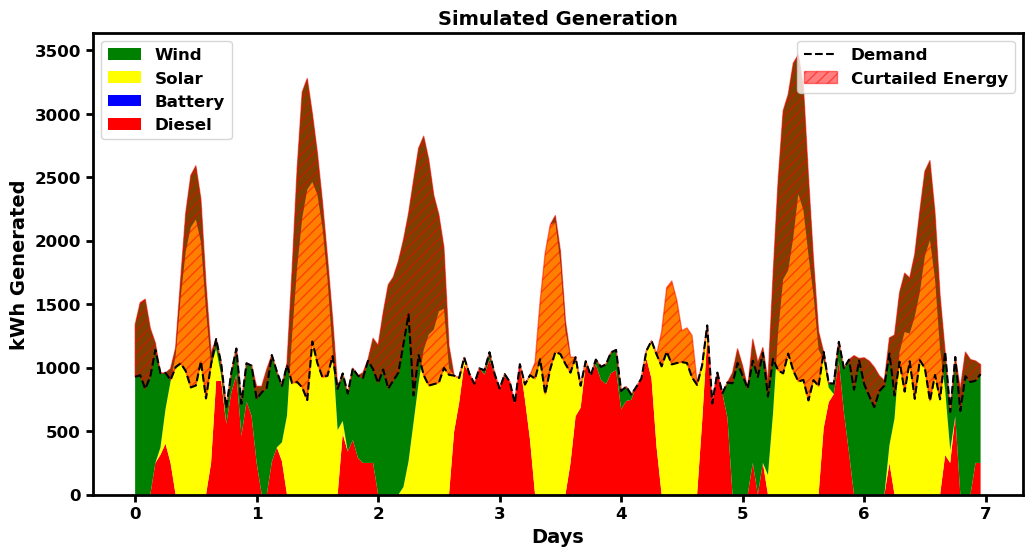

In [136]:
solarwind1 = [40,3000, 0, 2000,000,1]
print(calculate_carbon(solarwind1))
print(calculate_cost(solarwind1))
plot_generation(simulate_energy(solarwind1), '1999-4-1', '1999-4-7')


(44103.10887762158, 40296.21323852046, 3806.8956391011207, 205491.39000000272, 5731455.637967833)
(34935.883688012946, 25177.47985933846, 9758.403828674487, 128393.08999999962, 23850635.852909632)
(27944352.77600027, 20220352.77600027, 7724000)
(33082680.055999964, 12633880.055999963, 20448800)


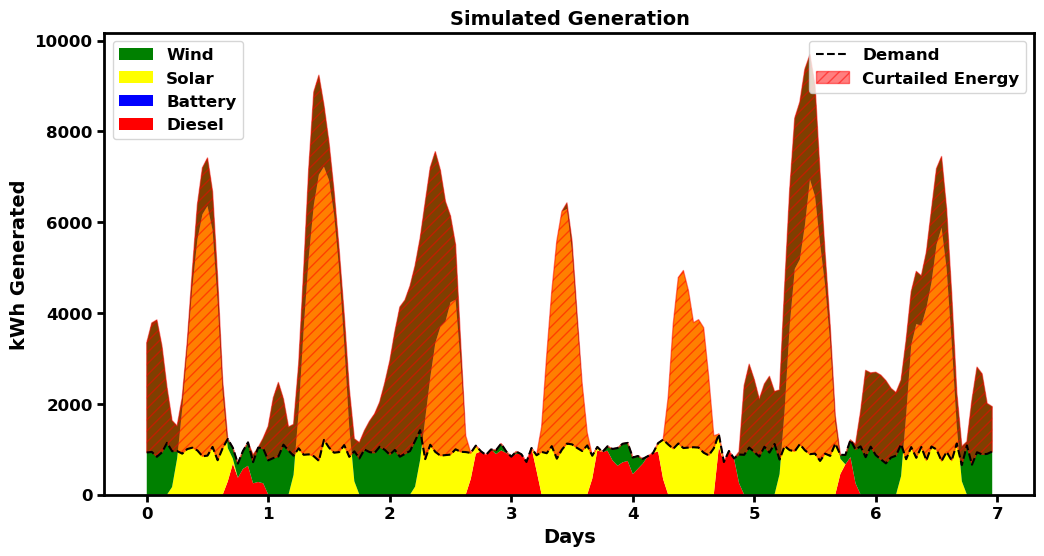

In [137]:
solarwind2 = [100,8800, 0, 2000,000,1]
print(calculate_carbon(solarwind1))
print(calculate_carbon(solarwind2))
print(calculate_cost(solarwind1))
print(calculate_cost(solarwind2))
plot_generation(simulate_energy(solarwind2), '1999-4-1', '1999-4-7')

## Cost

In [138]:
print(calculate_cost(base))
print(calculate_cost(solar1))
print(calculate_cost(solar2))
print(calculate_cost(solarBESS1))
print(calculate_cost(solarBESS2))
print(calculate_cost(wind1))
print(calculate_cost(wind2))
print(calculate_cost(windBESS1))
print(calculate_cost(windBESS2))
print(calculate_cost(solarwind1))
print(calculate_cost(solarwind2))
print(calculate_cost(hybrid1))
print(calculate_cost(hybrid2))
print(calculate_cost(renewable1))
print(calculate_cost(renewable2))


(61552791.60000007, 61552791.60000007, 0)
(40462454.61599997, 37834454.61599997, 2628000)
(40924735.48800014, 33215935.48800014, 7708800)
(32975718.144000217, 24347718.144000217, 8628000)
(23006249.60800001, 5297449.60800001, 17708800)
(40819264.90399991, 35723264.90399991, 5096000)
(39736054.760000296, 26996054.760000296, 12740000)
(43025654.62400002, 31929654.62400002, 11096000)
(40919230.75200013, 18179230.75200013, 22740000)
(27944352.77600027, 20220352.77600027, 7724000)
(33082680.055999964, 12633880.055999963, 20448800)
(22018705.736000016, 8294705.736000017, 13724000)
(31208415.528, 759615.5279999995, 30448800)
(45587600.0, 0.0, 45587600)
(49330000.0, 0.0, 49330000)


## Carbon

In [139]:
print(calculate_carbon(base))
print(calculate_carbon(solar1))
print(calculate_carbon(solar2))
print(calculate_carbon(solarBESS1))
print(calculate_carbon(solarBESS2))
print(calculate_carbon(wind1))
print(calculate_carbon(wind2))
print(calculate_carbon(windBESS1))
print(calculate_carbon(windBESS2))
print(calculate_cost(solarwind1))
print(calculate_cost(solarwind2))
print(calculate_carbon(hybrid1))
print(calculate_carbon(hybrid2))
print(calculate_carbon(renewable1))
print(calculate_carbon(renewable2))


(122665.73403624086, 122665.73403624086, 0.0, 625536.5000000007, 0.0)
(75955.08256867141, 75398.54857423675, 556.5339944346599, 384496.4899999997, 2328288.176165181)
(67827.01344132096, 66194.51372431262, 1632.499717008336, 337560.3200000014, 12256939.254335886)
(50397.98429111435, 48521.45029667969, 1876.53399443466, 247436.16000000222, 155526.98507966934)
(14389.543967870826, 10557.044250862491, 3832.499717008336, 53835.870000000104, 7803662.1725078495)
(74441.61711357725, 71191.25546891078, 3250.361644666461, 363041.3099999991, 2308697.2344546877)
(61925.102931723995, 53799.19882005785, 8125.904111666152, 274350.150000003, 9748011.426719565)
(68201.50525597605, 63631.14361130959, 4570.361644666461, 324488.3600000002, 1716213.8250752415)
(46554.45892522713, 36228.554813560986, 10325.904111666152, 184748.28000000134, 8359029.919501088)
(27944352.77600027, 20220352.77600027, 7724000)
(33082680.055999964, 12633880.055999963, 20448800)
(21657.03409867114, 16530.138459570022, 5126.8956391

## met demand

In [140]:
# #set the last value of each scenario to zero 
# solar1[-1] = 0
# solar2[-1] = 0
# solarBESS1[-1] = 0
# solarBESS2[-1] = 0
# wind1[-1] = 0
# wind2[-1] = 0
# windBESS1[-1] = 0
# windBESS2[-1] = 0
# solarwind1[-1] = 0
# solarwind2[-1] = 0
# hybrid1[-1] = 0
# hybrid2[-1] = 0
# renewable1 = [40,29200, 0, 2000, 30000,0]
# renewable2 = [100,27500, 0, 2000, 25000,0]
# renewable1[-1] = 0
# renewable2[-1] = 0
# #print the last value of met demand
# print(simulate_energy(solar1)['Metdemand'].iloc[-1])
# print(simulate_energy(solar2)['Metdemand'].iloc[-1])
# print(simulate_energy(solarBESS1)['Metdemand'].iloc[-1])
# print(simulate_energy(solarBESS2)['Metdemand'].iloc[-1])
# print(simulate_energy(wind1)['Metdemand'].iloc[-1])
# print(simulate_energy(wind2)['Metdemand'].iloc[-1])
# print(simulate_energy(windBESS1)['Metdemand'].iloc[-1])
# print(simulate_energy(windBESS2)['Metdemand'].iloc[-1])
# print(simulate_energy(solarwind1)['Metdemand'].iloc[-1])
# print(simulate_energy(solarwind2)['Metdemand'].iloc[-1])
# print(simulate_energy(hybrid1)['Metdemand'].iloc[-1])
# print(simulate_energy(hybrid2)['Metdemand'].iloc[-1])
# print(simulate_energy(renewable1)['Metdemand'].iloc[-1])
# print(simulate_energy(renewable2)['Metdemand'].iloc[-1])